In [143]:
# Se importan las librerías que se van a utilizar

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from CoolProp.CoolProp import PropsSI
from scipy.integrate import cumulative_trapezoid
from scipy import stats
import sympy as sp


In [144]:
#Función para aplicar incertidumbres dinámicamente a los valores del dataframe
def aplicar_incertidumbre(valor):
    return ufloat(valor, 0.001)

#Función para calcular el error aleatorio de variables ya calculadas
def aplicar_incertidumbre2(lista_mediciones,sis_error):
    lista_mediciones=[x.nominal_value for x in lista_mediciones]
    avg=np.mean(lista_mediciones)
    if len(lista_mediciones)>1:
        desv_est=np.std(lista_mediciones, ddof=1)
        #==================Valor de t-student=================
        IC = 0.95     # PASO 1. Intervalo de confianza
        alpha = 1 - IC      # PASO 2. Valor de alpha
        alpha_medios = alpha/2     # PASO 3. Valor de alpha/2
        n = len(lista_mediciones)     # PASO 4. Número de datos 
        v = n - 1     # PASO 5. Grados de libertad (DOF)
        valor = IC + alpha_medios     # PASO 6. Distr. t-Student (t)
        t = stats.t.ppf(valor, v)
        #======================================================
        rand_error=t*desv_est/sp.sqrt(n)
    else:
        rand_error=0
    total_error=sp.sqrt(rand_error**2+sis_error**2)
    return ufloat(avg, total_error)

def aplicar_incertidumbre3(lista_mediciones,sis_error):
    avg=np.mean(lista_mediciones)
    if len(lista_mediciones)>1:
        desv_est=np.std(lista_mediciones, ddof=1)
        #==================Valor de t-student=================
        IC = 0.95     # PASO 1. Intervalo de confianza
        alpha = 1 - IC      # PASO 2. Valor de alpha
        alpha_medios = alpha/2     # PASO 3. Valor de alpha/2
        n = len(lista_mediciones)     # PASO 4. Número de datos 
        v = n - 1     # PASO 5. Grados de libertad (DOF)
        valor = IC + alpha_medios     # PASO 6. Distr. t-Student (t)
        t = stats.t.ppf(valor, v)
        #======================================================
        rand_error=t*desv_est/sp.sqrt(n)
    else:
        rand_error=0
    total_error=sp.sqrt(rand_error**2+sis_error**2)
    return ufloat(avg, total_error)

#Función para calcular entalpías con incertidumbres
def calcular_entalpia_ufloat(presion, temperatura,columna):
    presion_nominal,presion_s,temperatura_nominal,temperatura_s=presion.nominal_value,presion.s,temperatura.nominal_value,temperatura.s
    values=[]
    for presion in [presion_nominal-presion_s,presion_nominal,presion_nominal+presion_s]:
        for temperatura in [temperatura_nominal-temperatura_s,temperatura_nominal,temperatura_nominal+temperatura_s]:
            try:
                values.append(PropsSI('H','P',presion,'T',temperatura,'Water'))
            except ValueError:
                print("Error en la llamada a la función PropsSI")
    min_value,max_value=min(values),max(values)
    return ufloat((min_value+max_value)/2,(max_value-min_value)/2)

#Función para calcular energia interna con incertidumbres
def calcular_energia_interna_ufloat(temperatura):
    temperatura_nominal,temperatura_s=temperatura.nominal_value,temperatura.s
    values=[]
    for temperatura in [temperatura_nominal-temperatura_s,temperatura_nominal,temperatura_nominal+temperatura_s]:
        try:
            values.append(PropsSI('U','Q',1,'T',temperatura,'Water'))
        except ValueError:
            print("Error en la llamada a la función PropsSI")
    min_value,max_value=min(values),max(values)
    return ufloat((min_value+max_value)/2,(max_value-min_value)/2)

#Función para calcular entropías con incertidumbres
def calcular_entropia_ufloat(presion,temperatura):
    presion_nominal,presion_s,temperatura_nominal,temperatura_s=presion.nominal_value,presion.s,temperatura.nominal_value,temperatura.s
    values=[]
    for presion in [presion_nominal-presion_s,presion_nominal,presion_nominal+presion_s]:
        for temperatura in [temperatura_nominal-temperatura_s,temperatura_nominal,temperatura_nominal+temperatura_s]:
            try:
                values.append(PropsSI('S','P',presion,'T',temperatura,'Water'))
            except ValueError:
                print("Error en la llamada a la función PropsSI")
    min_value,max_value=min(values),max(values)
    return ufloat((min_value+max_value)/2,(max_value-min_value)/2)

#Función para calcular entalpia con presion y entropia con incertidumbres
def calcular_entalpia_isentropica_ufloat(presion,entropia_entrada):
    presion_nominal,presion_s,entropia_entrada_nominal,entropia_entrada_s=presion.nominal_value,presion.s,entropia_entrada.nominal_value,entropia_entrada.s
    values=[]
    for presion in [presion_nominal-presion_s,presion_nominal,presion_nominal+presion_s]:
        for entropia in [entropia_entrada_nominal-entropia_entrada_s,entropia_entrada_nominal,entropia_entrada_nominal+entropia_entrada_s]:
            try:
                values.append(PropsSI('H','P',presion,'S',entropia,'Water'))
            except ValueError:
                print("Error en la llamada a la función PropsSI")
    min_value,max_value=min(values),max(values)
    return ufloat((min_value+max_value)/2,(max_value-min_value)/2)

#Funcion para integrar por trapecios con incertidumbres 
def integrar_ufloats(df,dt):
    values1 = [valor.nominal_value for valor in df]
    values2 = [valor.nominal_value for valor in dt]
    
    return cumulative_trapezoid(values1,values2,initial=0)

#Función para plotear incertidumbres con barras de error
def plot_ufloats(serie1,serie2,colore="firebrick"):
    # Extraer valores medidos y incertidumbres
    if type(serie1[2])==float:
        values1=serie1
        unc1=[0]*len(values1)
    else:
        values1 = [valor.nominal_value for valor in serie1]
        unc1 = [valor.std_dev for valor in serie1]
        
    if type(serie2[2])==float:
        values2=serie2
        unc2=[0]*len(values2)
    else:
        values2 = [valor.nominal_value for valor in serie2]
        unc2 = [valor.std_dev for valor in serie2]

    plt.errorbar(values1,values2, xerr=unc1, yerr=unc2, color=colore,ecolor="#191717",elinewidth=0.75,capsize=1, capthick=0.75,linestyle=' ',marker="o",label="Datos experimentales",markersize=2)

#Función para plotear incertidumbres con barras de error
def plot_ufloats2(serie1,serie2,colore="firebrick"):
    # Extraer valores medidos y incertidumbres
    if type(serie1[0])==float:
        values1=serie1
        unc1=[0]*len(values1)
    else:
        values1 = [valor.nominal_value for valor in serie1]
        unc1 = [valor.std_dev for valor in serie1]
        
    if type(serie2[0])==float:
        values2=serie2
        unc2=[0]*len(values2)
    else:
        values2 = [valor.nominal_value for valor in serie2]
        unc2 = [valor.std_dev for valor in serie2]

    plt.errorbar(values1,values2, xerr=unc1, yerr=unc2, color=colore,ecolor="#191717",elinewidth=0.75,capsize=1, capthick=0.75,linestyle=' ',marker="o",label="Datos experimentales",markersize=4)

#Función para hacer regresiones de datos con barras de error
def interpolar(serie1,serie2,grado,colore="firebrick"):
    values1 = [valor.nominal_value for valor in serie1]
    values2 = [valor.nominal_value for valor in serie2]
    coef = np.polyfit(values1,values2,grado)
    poly1d_fn = np.poly1d(coef)
    x_fit = np.linspace(min(values1), max(values1), 100)
    if grado==2:
        plt.plot(x_fit, poly1d_fn(x_fit),'--', color=colore, linewidth=1, zorder=10)
    else:
        plt.plot(x_fit, poly1d_fn(x_fit),'--', color=colore, linewidth=1, zorder=10,label="Datos interpolados")
    return poly1d_fn

#Función para hacer regresiones de datos sin barras de error
def interpolar2(serie1,serie2,grado,colore="firebrick"):
    values1 = serie1
    values2 = serie2
    coef = np.polyfit(values1,values2,grado)
    poly1d_fn = np.poly1d(coef)
    x_fit = np.linspace(min(values1), max(values1), 100)

    y_pred = poly1d_fn(values1)
    # Calcular la suma de los residuos al cuadrado
    ss_res = np.sum((values2 - y_pred) ** 2)

    # Calcular la suma total de cuadrados
    ss_tot = np.sum((values2 - np.mean(values2)) ** 2)

    # Calcular R^2
    r2 = 1 - (ss_res / ss_tot)

    if grado==2:
        plt.plot(x_fit, poly1d_fn(x_fit),'--', color=colore, linewidth=1, zorder=10)
    else:
        plt.plot(x_fit, poly1d_fn(x_fit),'--', color=colore, linewidth=1, zorder=10,label="Datos interpolados (R^2 = "+str(round(r2,3))+")")
    return poly1d_fn

fontdictval={'fontsize': 11,'fontname': 'Times New Roman',"color":"black"}

#Función para dar formato a la gráfica
def grafica(titulo,ejex,ejey):
    #=======================Elaboracion ejes==================
    plt.title(titulo, fontdict=fontdictval)
    plt.ylabel(ejey, fontdict=fontdictval)
    plt.xlabel(ejex, fontdict=fontdictval)
    #==========================Enmallado=================================
    plt.tick_params(direction='out', length=5, width=0.75, grid_alpha=0.3)
    plt.minorticks_on()
    plt.grid(True)
    plt.grid(visible=True, which='major', color='grey', linestyle='-')
    plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', alpha=0.5)
    #=====================================================================
    plt.show()

In [145]:
#Se importan los datos experimentales
"Rankine	10/7/2024	8:10:56 AM"
df=pd.read_csv('Grupo5.txt', sep='\t', header=0)
df



,Time (sec),Boiler Temp (C),Turbine In Temp (C),Turbine Ex Temp (C),Boiler Pres (psig),Turbine In Pres (psig),Turbine Ex Pres (psig),Fuel Flow (L/min),Generator (RPM),Voltage (Volts),Current (Amps),Power (Watts)
0,351.917,16.942,16.973,17.001,0.424,0.073,0.085,0.002,0.147,0.133,-0.006,-0.001
1,352.917,17.010,16.957,16.978,0.426,0.073,0.085,0.003,0.274,0.133,-0.006,-0.001
2,353.917,16.939,16.909,16.934,0.425,0.073,0.085,0.003,0.287,0.133,-0.006,-0.001
3,354.916,16.999,16.967,17.016,0.427,0.073,0.086,0.002,0.299,0.133,-0.006,-0.001
4,355.916,16.883,16.966,17.022,0.426,0.073,0.085,0.003,0.137,0.134,-0.006,-0.001
...,...,...,...,...,...,...,...,...,...,...,...,...
2166,2520.073,175.937,117.882,97.632,110.759,15.308,4.676,1.844,1693.091,6.481,0.269,1.741
2167,2521.074,176.008,117.845,97.622,110.198,15.180,4.594,1.643,1680.239,6.432,0.267,1.714
2168,2522.073,175.875,117.616,97.601,109.674,15.061,4.532,1.464,1654.957,6.338,0.262,1.663
2169,2523.073,175.976,117.575,97.556,109.132,14.983,4.501,1.306,1697.941,6.500,0.269,1.752


In [146]:
#Seteamos el tiempo para que inice en 0
df['Time (sec)']=df['Time (sec)']-df['Time (sec)'][0]
df

,Time (sec),Boiler Temp (C),Turbine In Temp (C),Turbine Ex Temp (C),Boiler Pres (psig),Turbine In Pres (psig),Turbine Ex Pres (psig),Fuel Flow (L/min),Generator (RPM),Voltage (Volts),Current (Amps),Power (Watts)
0,0.000,16.942,16.973,17.001,0.424,0.073,0.085,0.002,0.147,0.133,-0.006,-0.001
1,1.000,17.010,16.957,16.978,0.426,0.073,0.085,0.003,0.274,0.133,-0.006,-0.001
2,2.000,16.939,16.909,16.934,0.425,0.073,0.085,0.003,0.287,0.133,-0.006,-0.001
3,2.999,16.999,16.967,17.016,0.427,0.073,0.086,0.002,0.299,0.133,-0.006,-0.001
4,3.999,16.883,16.966,17.022,0.426,0.073,0.085,0.003,0.137,0.134,-0.006,-0.001
...,...,...,...,...,...,...,...,...,...,...,...,...
2166,2168.156,175.937,117.882,97.632,110.759,15.308,4.676,1.844,1693.091,6.481,0.269,1.741
2167,2169.157,176.008,117.845,97.622,110.198,15.180,4.594,1.643,1680.239,6.432,0.267,1.714
2168,2170.156,175.875,117.616,97.601,109.674,15.061,4.532,1.464,1654.957,6.338,0.262,1.663
2169,2171.156,175.976,117.575,97.556,109.132,14.983,4.501,1.306,1697.941,6.500,0.269,1.752


In [147]:
#Aplicamos incertidumbres a los datos experimentales
for column in df.columns:
    df[column] = df[column].apply(aplicar_incertidumbre)

In [148]:
# Pasamos todas las unidades para que funcionen con coolprop
df["Boiler Temp (K)"]=df["Boiler Temp (C)"]+273.15

#Repetimos lo mismo para todo lo demás
df["Turbine In Temp (K)"]=df["Turbine In Temp (C)"]+273.15

df["Turbine Ex Temp (K)"]=df["Turbine Ex Temp (C)"]+273.15

#En la presión sumamos la presión atmosférica para obtener la presión absoluta

df["Boiler Pres (Pa)"]=df["Boiler Pres (psig)"]*6894.76+7548
 
df["Turbine In Pres (Pa)"]=df["Turbine In Pres (psig)"]*6894.76+7548

df["Turbine Ex Pres (Pa)"]=df["Turbine Ex Pres (psig)"]*6894.76+7548

#Flujo masico
df["Fuel Flow (m^3/min)"]=df["Fuel Flow (L/min)"]/1000

#Borramos todas las columnas viejas
df=df.drop(columns=['Turbine In Temp (C)','Turbine Ex Temp (C)','Boiler Temp (C)','Boiler Pres (psig)','Turbine In Pres (psig)','Turbine Ex Pres (psig)','Fuel Flow (L/min)'])

df

,Time (sec),Generator (RPM),Voltage (Volts),Current (Amps),Power (Watts),Boiler Temp (K),Turbine In Temp (K),Turbine Ex Temp (K),Boiler Pres (Pa),Turbine In Pres (Pa),Turbine Ex Pres (Pa),Fuel Flow (m^3/min)
0,0.0000+/-0.0010,0.1470+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0920+/-0.0010,290.1230+/-0.0010,290.1510+/-0.0010,10471+/-7,8051+/-7,8134+/-7,(2.0+/-1.0)e-06
1,1.0000+/-0.0010,0.2740+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.1600+/-0.0010,290.1070+/-0.0010,290.1280+/-0.0010,10485+/-7,8051+/-7,8134+/-7,(3.0+/-1.0)e-06
2,2.0000+/-0.0010,0.2870+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0890+/-0.0010,290.0590+/-0.0010,290.0840+/-0.0010,10478+/-7,8051+/-7,8134+/-7,(3.0+/-1.0)e-06
3,2.9990+/-0.0010,0.2990+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.1490+/-0.0010,290.1170+/-0.0010,290.1660+/-0.0010,10492+/-7,8051+/-7,8141+/-7,(2.0+/-1.0)e-06
4,3.9990+/-0.0010,0.1370+/-0.0010,0.1340+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0330+/-0.0010,290.1160+/-0.0010,290.1720+/-0.0010,10485+/-7,8051+/-7,8134+/-7,(3.0+/-1.0)e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
2166,2168.1560+/-0.0010,1693.0910+/-0.0010,6.4810+/-0.0010,0.2690+/-0.0010,1.7410+/-0.0010,449.0870+/-0.0010,391.0320+/-0.0010,370.7820+/-0.0010,771205+/-7,113093+/-7,39788+/-7,0.0018440+/-0.0000010
2167,2169.1570+/-0.0010,1680.2390+/-0.0010,6.4320+/-0.0010,0.2670+/-0.0010,1.7140+/-0.0010,449.1580+/-0.0010,390.9950+/-0.0010,370.7720+/-0.0010,767337+/-7,112210+/-7,39223+/-7,0.0016430+/-0.0000010
2168,2170.1560+/-0.0010,1654.9570+/-0.0010,6.3380+/-0.0010,0.2620+/-0.0010,1.6630+/-0.0010,449.0250+/-0.0010,390.7660+/-0.0010,370.7510+/-0.0010,763724+/-7,111390+/-7,38795+/-7,0.0014640+/-0.0000010
2169,2171.1560+/-0.0010,1697.9410+/-0.0010,6.5000+/-0.0010,0.2690+/-0.0010,1.7520+/-0.0010,449.1260+/-0.0010,390.7250+/-0.0010,370.7060+/-0.0010,759987+/-7,110852+/-7,38581+/-7,0.0013060+/-0.0000010


In [149]:
#Calculamos las entalpías en turbina y caldera
df["Boiler Enthalpy (J/kg)"]=df.apply(lambda row: calcular_entalpia_ufloat(row["Boiler Pres (Pa)"],row["Boiler Temp (K)"],"Boiler"),axis=1)
df["Boiler Gas Internal Energy (J/kg)"]=df.apply(lambda row: calcular_energia_interna_ufloat(row["Boiler Temp (K)"]),axis=1)
df["Turbine In Enthalpy (J/kg)"]=df.apply(lambda row: calcular_entalpia_ufloat(row["Turbine In Pres (Pa)"],row["Turbine In Temp (K)"],"Turbine In"),axis=1)
df["Turbine Ex Enthalpy (J/kg)"]=df.apply(lambda row: calcular_entalpia_ufloat(row["Turbine Ex Pres (Pa)"],row["Turbine Ex Temp (K)"],"Turbine Ex"),axis=1)

#Se calculan las entalpías de entrada y salida de la turbina
df["Boiler Entropy (J/kg)"]=df.apply(lambda row: calcular_entropia_ufloat(row["Boiler Pres (Pa)"],row["Boiler Temp (K)"]),axis=1)

df["Turbine In Entropy (J/kg)"]=df.apply(lambda row: calcular_entropia_ufloat(row["Turbine In Pres (Pa)"],row["Turbine In Temp (K)"]),axis=1)
df["Turbine Ex Entropy (J/kg)"]=df.apply(lambda row: calcular_entropia_ufloat(row["Turbine Ex Pres (Pa)"],row["Turbine Ex Temp (K)"]),axis=1)   
df["Turbine Ex Enthalpy Isentropic (J/kg)"]=df.apply(lambda row: calcular_entalpia_isentropica_ufloat(row["Turbine Ex Pres (Pa)"],row["Turbine In Entropy (J/kg)"]),axis=1)

In [150]:
df

,Time (sec),Generator (RPM),Voltage (Volts),Current (Amps),Power (Watts),Boiler Temp (K),Turbine In Temp (K),Turbine Ex Temp (K),Boiler Pres (Pa),Turbine In Pres (Pa),Turbine Ex Pres (Pa),Fuel Flow (m^3/min),Boiler Enthalpy (J/kg),Boiler Gas Internal Energy (J/kg),Turbine In Enthalpy (J/kg),Turbine Ex Enthalpy (J/kg),Boiler Entropy (J/kg),Turbine In Entropy (J/kg),Turbine Ex Entropy (J/kg),Turbine Ex Enthalpy Isentropic (J/kg)
0,0.0000+/-0.0010,0.1470+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0920+/-0.0010,290.1230+/-0.0010,290.1510+/-0.0010,10471+/-7,8051+/-7,8134+/-7,(2.0+/-1.0)e-06,71122+/-4,2398148.2+/-1.4,71250+/-4,71367+/-4,252.591+/-0.014,253.039+/-0.014,253.443+/-0.014,71250+/-4
1,1.0000+/-0.0010,0.2740+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.1600+/-0.0010,290.1070+/-0.0010,290.1280+/-0.0010,10485+/-7,8051+/-7,8134+/-7,(3.0+/-1.0)e-06,71407+/-4,2398241.1+/-1.4,71183+/-4,71271+/-4,253.572+/-0.014,252.808+/-0.014,253.111+/-0.014,71183+/-4
2,2.0000+/-0.0010,0.2870+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0890+/-0.0010,290.0590+/-0.0010,290.0840+/-0.0010,10478+/-7,8051+/-7,8134+/-7,(3.0+/-1.0)e-06,71110+/-4,2398144.2+/-1.4,70982+/-4,71087+/-4,252.548+/-0.014,252.115+/-0.014,252.476+/-0.014,70982+/-4
3,2.9990+/-0.0010,0.2990+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.1490+/-0.0010,290.1170+/-0.0010,290.1660+/-0.0010,10492+/-7,8051+/-7,8141+/-7,(2.0+/-1.0)e-06,71361+/-4,2398226.1+/-1.4,71225+/-4,71430+/-4,253.414+/-0.014,252.952+/-0.014,253.659+/-0.014,71225+/-4
4,3.9990+/-0.0010,0.1370+/-0.0010,0.1340+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0330+/-0.0010,290.1160+/-0.0010,290.1720+/-0.0010,10485+/-7,8051+/-7,8134+/-7,(3.0+/-1.0)e-06,70875+/-4,2398067.6+/-1.4,71221+/-4,71455+/-4,251.739+/-0.014,252.938+/-0.014,253.746+/-0.014,71221+/-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166,2168.1560+/-0.0010,1693.0910+/-0.0010,6.4810+/-0.0010,0.2690+/-0.0010,1.7410+/-0.0010,449.0870+/-0.0010,391.0320+/-0.0010,370.7820+/-0.0010,771205+/-7,113093+/-7,39788+/-7,0.0018440+/-0.0000010,2784543.9+/-3.0,2580048.7+/-0.7,2710956.9+/-2.8,2679095.8+/-2.9,6713.947+/-0.011,7397.199+/-0.035,7791.09+/-0.09,(2.54038+/-0.00004)e+06
2167,2169.1570+/-0.0010,1680.2390+/-0.0010,6.4320+/-0.0010,0.2670+/-0.0010,1.7140+/-0.0010,449.1580+/-0.0010,390.9950+/-0.0010,370.7720+/-0.0010,767337+/-7,112210+/-7,39223+/-7,0.0016430+/-0.0000010,2785005.8+/-3.0,2580098.5+/-0.7,2710976.3+/-2.8,2679150.5+/-2.9,6717.170+/-0.011,7400.815+/-0.035,7797.80+/-0.09,(2.53945+/-0.00004)e+06
2168,2170.1560+/-0.0010,1654.9570+/-0.0010,6.3380+/-0.0010,0.2620+/-0.0010,1.6630+/-0.0010,449.0250+/-0.0010,390.7660+/-0.0010,370.7510+/-0.0010,763724+/-7,111390+/-7,38795+/-7,0.0014640+/-0.0000010,2784946.4+/-3.0,2580005.2+/-0.7,2710597.4+/-2.8,2679165.6+/-2.9,6719.097+/-0.011,7403.187+/-0.035,7802.87+/-0.09,(2.53860+/-0.00004)e+06
2169,2171.1560+/-0.0010,1697.9410+/-0.0010,6.5000+/-0.0010,0.2690+/-0.0010,1.7520+/-0.0010,449.1260+/-0.0010,390.7250+/-0.0010,370.7060+/-0.0010,759987+/-7,110852+/-7,38581+/-7,0.0013060+/-0.0000010,2785470.8+/-3.0,2580076.1+/-0.7,2710571.7+/-2.8,2679105.7+/-2.9,6722.407+/-0.011,7405.325+/-0.035,7805.24+/-0.09,(2.53850+/-0.00004)e+06


In [151]:
#Calculamos la eficiencia isentrópica
df["Eficiencia Isentropica"]=(df["Turbine In Enthalpy (J/kg)"]-df["Turbine Ex Enthalpy (J/kg)"])/(df["Turbine In Enthalpy (J/kg)"]-df["Turbine Ex Enthalpy Isentropic (J/kg)"])*100

df

,Time (sec),Generator (RPM),Voltage (Volts),Current (Amps),Power (Watts),Boiler Temp (K),Turbine In Temp (K),Turbine Ex Temp (K),Boiler Pres (Pa),Turbine In Pres (Pa),...,Fuel Flow (m^3/min),Boiler Enthalpy (J/kg),Boiler Gas Internal Energy (J/kg),Turbine In Enthalpy (J/kg),Turbine Ex Enthalpy (J/kg),Boiler Entropy (J/kg),Turbine In Entropy (J/kg),Turbine Ex Entropy (J/kg),Turbine Ex Enthalpy Isentropic (J/kg),Eficiencia Isentropica
0,0.0000+/-0.0010,0.1470+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0920+/-0.0010,290.1230+/-0.0010,290.1510+/-0.0010,10471+/-7,8051+/-7,...,(2.0+/-1.0)e-06,71122+/-4,2398148.2+/-1.4,71250+/-4,71367+/-4,252.591+/-0.014,253.039+/-0.014,253.443+/-0.014,71250+/-4,(0.0+/-1.0)e+07
1,1.0000+/-0.0010,0.2740+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.1600+/-0.0010,290.1070+/-0.0010,290.1280+/-0.0010,10485+/-7,8051+/-7,...,(3.0+/-1.0)e-06,71407+/-4,2398241.1+/-1.4,71183+/-4,71271+/-4,253.572+/-0.014,252.808+/-0.014,253.111+/-0.014,71183+/-4,(0+/-8)e+06
2,2.0000+/-0.0010,0.2870+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0890+/-0.0010,290.0590+/-0.0010,290.0840+/-0.0010,10478+/-7,8051+/-7,...,(3.0+/-1.0)e-06,71110+/-4,2398144.2+/-1.4,70982+/-4,71087+/-4,252.548+/-0.014,252.115+/-0.014,252.476+/-0.014,70982+/-4,(0+/-9)e+06
3,2.9990+/-0.0010,0.2990+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.1490+/-0.0010,290.1170+/-0.0010,290.1660+/-0.0010,10492+/-7,8051+/-7,...,(2.0+/-1.0)e-06,71361+/-4,2398226.1+/-1.4,71225+/-4,71430+/-4,253.414+/-0.014,252.952+/-0.014,253.659+/-0.014,71225+/-4,(0.0+/-1.5)e+07
4,3.9990+/-0.0010,0.1370+/-0.0010,0.1340+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0330+/-0.0010,290.1160+/-0.0010,290.1720+/-0.0010,10485+/-7,8051+/-7,...,(3.0+/-1.0)e-06,70875+/-4,2398067.6+/-1.4,71221+/-4,71455+/-4,251.739+/-0.014,252.938+/-0.014,253.746+/-0.014,71221+/-4,(0.0+/-2.0)e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166,2168.1560+/-0.0010,1693.0910+/-0.0010,6.4810+/-0.0010,0.2690+/-0.0010,1.7410+/-0.0010,449.0870+/-0.0010,391.0320+/-0.0010,370.7820+/-0.0010,771205+/-7,113093+/-7,...,0.0018440+/-0.0000010,2784543.9+/-3.0,2580048.7+/-0.7,2710956.9+/-2.8,2679095.8+/-2.9,6713.947+/-0.011,7397.199+/-0.035,7791.09+/-0.09,(2.54038+/-0.00004)e+06,18.678+/-0.005
2167,2169.1570+/-0.0010,1680.2390+/-0.0010,6.4320+/-0.0010,0.2670+/-0.0010,1.7140+/-0.0010,449.1580+/-0.0010,390.9950+/-0.0010,370.7720+/-0.0010,767337+/-7,112210+/-7,...,0.0016430+/-0.0000010,2785005.8+/-3.0,2580098.5+/-0.7,2710976.3+/-2.8,2679150.5+/-2.9,6717.170+/-0.011,7400.815+/-0.035,7797.80+/-0.09,(2.53945+/-0.00004)e+06,18.554+/-0.005
2168,2170.1560+/-0.0010,1654.9570+/-0.0010,6.3380+/-0.0010,0.2620+/-0.0010,1.6630+/-0.0010,449.0250+/-0.0010,390.7660+/-0.0010,370.7510+/-0.0010,763724+/-7,111390+/-7,...,0.0014640+/-0.0000010,2784946.4+/-3.0,2580005.2+/-0.7,2710597.4+/-2.8,2679165.6+/-2.9,6719.097+/-0.011,7403.187+/-0.035,7802.87+/-0.09,(2.53860+/-0.00004)e+06,18.274+/-0.005
2169,2171.1560+/-0.0010,1697.9410+/-0.0010,6.5000+/-0.0010,0.2690+/-0.0010,1.7520+/-0.0010,449.1260+/-0.0010,390.7250+/-0.0010,370.7060+/-0.0010,759987+/-7,110852+/-7,...,0.0013060+/-0.0000010,2785470.8+/-3.0,2580076.1+/-0.7,2710571.7+/-2.8,2679105.7+/-2.9,6722.407+/-0.011,7405.325+/-0.035,7805.24+/-0.09,(2.53850+/-0.00004)e+06,18.287+/-0.005


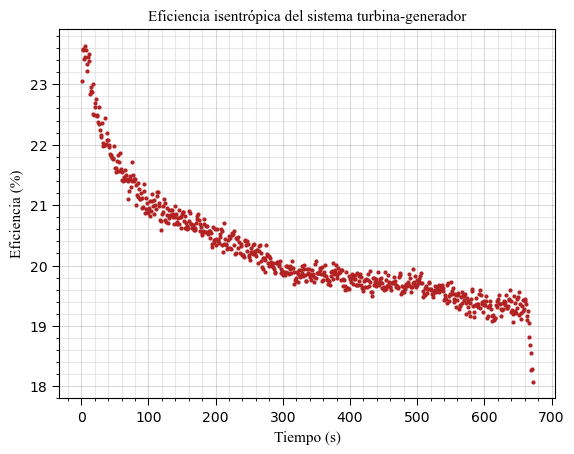

In [152]:
#Plot eficiencia isentrópica
serie_tiempo=df["Time (sec)"][df["Time (sec)"]>1500]
serie_eficiencia=df["Eficiencia Isentropica"][df["Time (sec)"]>1500]

serie_tiempo=[x.nominal_value-1500 for x in serie_tiempo]
serie_eficiencia=[x.nominal_value for x in serie_eficiencia]

plt.plot(serie_tiempo,serie_eficiencia,marker="o",linestyle=' ',markersize=2,color="firebrick")
grafica("Eficiencia isentrópica del sistema turbina-generador","Tiempo (s)","Eficiencia (%)")

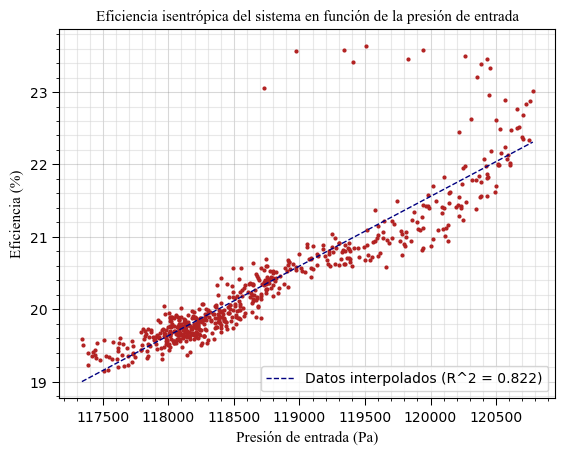

In [153]:
#Regresión de la eficiencia con la presión de entrada
presion=[x.nominal_value for x in df["Turbine In Pres (Pa)"][df["Time (sec)"]>1500]]
plt.plot(presion[0:600],serie_eficiencia[0:600],marker="o",linestyle=' ',markersize=2,color="firebrick")
interpolar2(presion[0:600],serie_eficiencia[0:600],1,colore="navy")
plt.legend(loc="best")
grafica("Eficiencia isentrópica del sistema en función de la presión de entrada","Presión de entrada (Pa)","Eficiencia (%)")


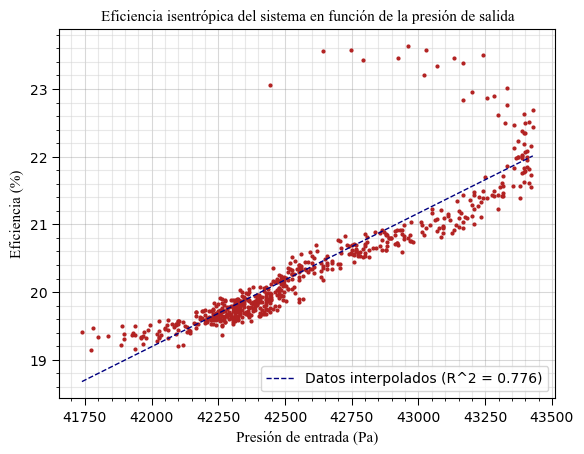

In [154]:
#Regresión de la eficiencia con la presión de salida
presion2=[x.nominal_value for x in df["Turbine Ex Pres (Pa)"][df["Time (sec)"]>1500]]
plt.plot(presion2[0:600],serie_eficiencia[0:600],marker="o",linestyle=' ',markersize=2,color="firebrick")
interpolar2(presion2[0:600],serie_eficiencia[0:600],1,colore="navy")
plt.legend(loc="best")
grafica("Eficiencia isentrópica del sistema en función de la presión de salida","Presión de entrada (Pa)","Eficiencia (%)")


In [155]:
#Eficiencia con el error aleatorio
aplicar_incertidumbre3(serie_eficiencia,0.1)

20.2173063482459+/-0.12161216751517426

In [156]:
#Calculamos el flujo másico de agua teniendo en cuenta los volúmenes iniciales, finales, densidad del agua y el tiempo
m_dot_water=(0.0048-0.0016)*PropsSI("D","T",289.15,"P",75483,"Water")/600

#Calculamos la potencia disponible cuando pasa el fluido por la turbina
df["Potencia disponible (W)"]=m_dot_water*(df["Turbine In Enthalpy (J/kg)"]-df["Turbine Ex Enthalpy (J/kg)"])

#Calculamos la eficiencia como la potencia electrica sobte la potencia disponible
df["Eficiencia"]=df["Power (Watts)"]/df["Potencia disponible (W)"]*100



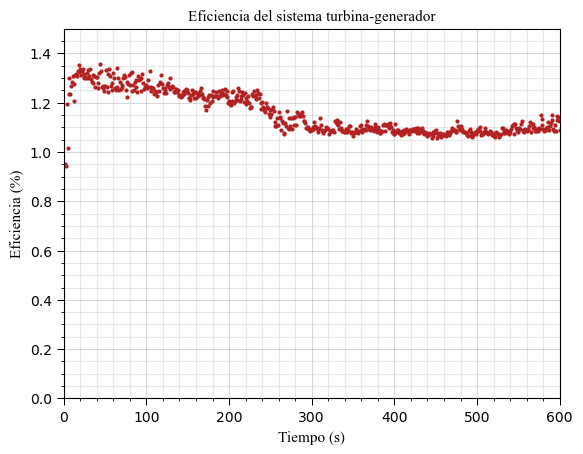

In [157]:
#Graficamos la eficiencia energética en función del tiempo
plot_ufloats(df['Time (sec)']-1500,df['Eficiencia'])
plt.ylim([0,1.5])
plt.xlim([0,600])
grafica("Eficiencia del sistema turbina-generador","Tiempo (s)","Eficiencia (%)")

In [158]:
#Eficiencia energética con el error aleatorio
aplicar_incertidumbre2(df['Eficiencia'][df["Time (sec)"]>1500],0.1)

1.1521034394820946+/-0.1002084134006675

In [159]:
#Calculamos la capacidad calorífica del propano volumétrica
capacidad_calorifica=PropsSI('H',"Q",1,'T',288.15,'n-Propane')*10*PropsSI('D',"Q",1,'T',288.15,'n-Propane')


In [160]:
#Calculamos la potencia calorífica que podría dar el propano
df["Q_available_boiler (J/min)"]=capacidad_calorifica*df["Fuel Flow (m^3/min)"]
df["Q_available_boiler (J/s)"]=df["Q_available_boiler (J/min)"]/60
df["Q_available_boiler_integrate (J)"]= integrar_ufloats(df["Q_available_boiler (J/s)"],df["Time (sec)"])


df["Q_added_boiler (J/min)"]=m_dot_water*60*(df["Boiler Enthalpy (J/kg)"])
df["Q_added_boiler (J/s)"]=df["Q_added_boiler (J/min)"]/60

df_seted=(df[df["Time (sec)"]>1500]).reset_index(drop=True)
df_seted["Q_added_boiler_integrate (J)"]= integrar_ufloats(df_seted["Q_added_boiler (J/s)"],df_seted["Time (sec)"])

df_seted

,Time (sec),Generator (RPM),Voltage (Volts),Current (Amps),Power (Watts),Boiler Temp (K),Turbine In Temp (K),Turbine Ex Temp (K),Boiler Pres (Pa),Turbine In Pres (Pa),...,Turbine Ex Enthalpy Isentropic (J/kg),Eficiencia Isentropica,Potencia disponible (W),Eficiencia,Q_available_boiler (J/min),Q_available_boiler (J/s),Q_available_boiler_integrate (J),Q_added_boiler (J/min),Q_added_boiler (J/s),Q_added_boiler_integrate (J)
0,1500.9450+/-0.0010,1792.9640+/-0.0010,6.8570+/-0.0010,0.4670+/-0.0010,3.2050+/-0.0010,449.1760+/-0.0010,390.5830+/-0.0010,366.6530+/-0.0010,821950+/-7,118726+/-7,...,(2.54118+/-0.00004)e+06,23.061+/-0.005,206.710+/-0.022,1.5505+/-0.0005,(4.6139+/-0.0009)e+05,7689.8+/-1.6,8.868634e+06,888952.7+/-1.0,14815.878+/-0.016,0.000000e+00
1,1501.9450+/-0.0010,1658.3560+/-0.0010,6.3520+/-0.0010,0.3150+/-0.0010,2.0010+/-0.0010,449.2690+/-0.0010,390.8290+/-0.0010,366.5220+/-0.0010,821771+/-7,118974+/-7,...,(2.54200+/-0.00004)e+06,23.562+/-0.006,210.778+/-0.022,0.9493+/-0.0005,(4.6157+/-0.0009)e+05,7692.9+/-1.6,8.876326e+06,889032.2+/-1.0,14817.203+/-0.016,1.481654e+04
2,1502.9450+/-0.0010,1851.9900+/-0.0010,7.0780+/-0.0010,0.2810+/-0.0010,1.9880+/-0.0010,449.2770+/-0.0010,390.9750+/-0.0010,366.6310+/-0.0010,821206+/-7,119340+/-7,...,(2.54211+/-0.00004)e+06,23.578+/-0.006,211.096+/-0.022,0.9418+/-0.0005,(4.6195+/-0.0009)e+05,7699.1+/-1.6,8.884022e+06,889052.4+/-1.0,14817.540+/-0.016,2.963391e+04
3,1503.9450+/-0.0010,1831.3900+/-0.0010,7.0020+/-0.0010,0.3580+/-0.0010,2.5050+/-0.0010,449.1220+/-0.0010,391.0420+/-0.0010,366.8420+/-0.0010,821164+/-7,119409+/-7,...,(2.54231+/-0.00004)e+06,23.421+/-0.006,209.611+/-0.022,1.1951+/-0.0005,(4.6223+/-0.0009)e+05,7703.8+/-1.6,8.891723e+06,888928.3+/-1.0,14815.471+/-0.016,4.445042e+04
4,1504.9450+/-0.0010,1949.5330+/-0.0010,7.4440+/-0.0010,0.2860+/-0.0010,2.1310+/-0.0010,449.3300+/-0.0010,391.2260+/-0.0010,366.9770+/-0.0010,820702+/-7,119829+/-7,...,(2.54252+/-0.00004)e+06,23.454+/-0.006,210.061+/-0.022,1.0145+/-0.0005,(4.6185+/-0.0009)e+05,7697.6+/-1.6,8.899424e+06,889107.5+/-1.0,14818.458+/-0.016,5.926738e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,2168.1560+/-0.0010,1693.0910+/-0.0010,6.4810+/-0.0010,0.2690+/-0.0010,1.7410+/-0.0010,449.0870+/-0.0010,391.0320+/-0.0010,370.7820+/-0.0010,771205+/-7,113093+/-7,...,(2.54038+/-0.00004)e+06,18.678+/-0.005,169.745+/-0.021,1.0257+/-0.0006,(1.7230+/-0.0009)e+05,2871.6+/-1.6,1.398973e+07,890104.2+/-1.0,14835.070+/-0.016,9.891252e+06
668,2169.1570+/-0.0010,1680.2390+/-0.0010,6.4320+/-0.0010,0.2670+/-0.0010,1.7140+/-0.0010,449.1580+/-0.0010,390.9950+/-0.0010,370.7720+/-0.0010,767337+/-7,112210+/-7,...,(2.53945+/-0.00004)e+06,18.554+/-0.005,169.556+/-0.021,1.0109+/-0.0006,(1.5352+/-0.0009)e+05,2558.6+/-1.6,1.399244e+07,890251.9+/-0.9,14837.531+/-0.016,9.906104e+06
669,2170.1560+/-0.0010,1654.9570+/-0.0010,6.3380+/-0.0010,0.2620+/-0.0010,1.6630+/-0.0010,449.0250+/-0.0010,390.7660+/-0.0010,370.7510+/-0.0010,763724+/-7,111390+/-7,...,(2.53860+/-0.00004)e+06,18.274+/-0.005,167.457+/-0.021,0.9931+/-0.0006,(1.3679+/-0.0009)e+05,2279.8+/-1.6,1.399486e+07,890232.9+/-0.9,14837.215+/-0.016,9.920926e+06
670,2171.1560+/-0.0010,1697.9410+/-0.0010,6.5000+/-0.0010,0.2690+/-0.0010,1.7520+/-0.0010,449.1260+/-0.0010,390.7250+/-0.0010,370.7060+/-0.0010,759987+/-7,110852+/-7,...,(2.53850+/-0.00004)e+06,18.287+/-0.005,167.640+/-0.021,1.0451+/-0.0006,(1.2203+/-0.0009)e+05,2033.8+/-1.6,1.399702e+07,890400.5+/-0.9,14840.009+/-0.016,9.935765e+06


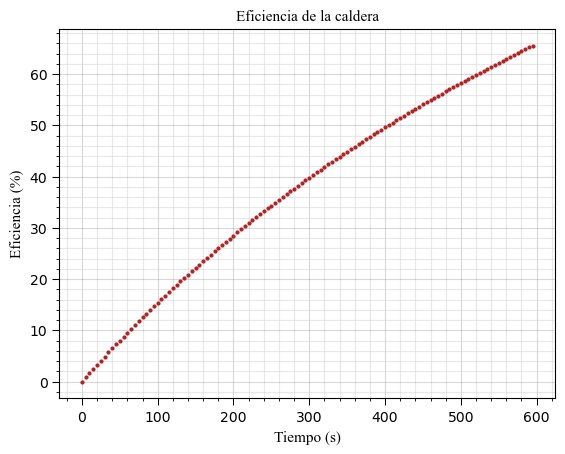

In [161]:
#Eficiencia en la caldera
eficiencia=df_seted["Q_added_boiler_integrate (J)"]/df_seted["Q_available_boiler_integrate (J)"]*100

plt.plot(eficiencia.index[0:600:5],eficiencia[0:600:5],marker="o",markersize=2,linestyle=" ",color="firebrick")
grafica("Eficiencia de la caldera",ejex="Tiempo (s)",ejey="Eficiencia (%)")

In [162]:
#Se calcula la eficiencia del ciclo
df["Eficiencia_ciclo"]=df["Power (Watts)"]/df["Q_available_boiler (J/s)"]*100

df

,Time (sec),Generator (RPM),Voltage (Volts),Current (Amps),Power (Watts),Boiler Temp (K),Turbine In Temp (K),Turbine Ex Temp (K),Boiler Pres (Pa),Turbine In Pres (Pa),...,Turbine Ex Enthalpy Isentropic (J/kg),Eficiencia Isentropica,Potencia disponible (W),Eficiencia,Q_available_boiler (J/min),Q_available_boiler (J/s),Q_available_boiler_integrate (J),Q_added_boiler (J/min),Q_added_boiler (J/s),Eficiencia_ciclo
0,0.0000+/-0.0010,0.1470+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0920+/-0.0010,290.1230+/-0.0010,290.1510+/-0.0010,10471+/-7,8051+/-7,...,71250+/-4,(0.0+/-1.0)e+07,-0.625+/-0.032,0.16+/-0.16,(1.9+/-0.9)e+02,3.1+/-1.6,0.000000e+00,22734.9+/-1.3,378.916+/-0.022,-0.03+/-0.04
1,1.0000+/-0.0010,0.2740+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.1600+/-0.0010,290.1070+/-0.0010,290.1280+/-0.0010,10485+/-7,8051+/-7,...,71183+/-4,(0+/-8)e+06,-0.469+/-0.032,0.21+/-0.21,(2.8+/-0.9)e+02,4.7+/-1.6,3.893168e+00,22825.9+/-1.3,380.432+/-0.022,-0.021+/-0.023
2,2.0000+/-0.0010,0.2870+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0890+/-0.0010,290.0590+/-0.0010,290.0840+/-0.0010,10478+/-7,8051+/-7,...,70982+/-4,(0+/-9)e+06,-0.558+/-0.032,0.18+/-0.18,(2.8+/-0.9)e+02,4.7+/-1.6,8.564969e+00,22730.9+/-1.3,378.849+/-0.022,-0.021+/-0.023
3,2.9990+/-0.0010,0.2990+/-0.0010,0.1330+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.1490+/-0.0010,290.1170+/-0.0010,290.1660+/-0.0010,10492+/-7,8051+/-7,...,71225+/-4,(0.0+/-1.5)e+07,-1.093+/-0.032,0.09+/-0.09,(1.9+/-0.9)e+02,3.1+/-1.6,1.245424e+01,22811.2+/-1.3,380.187+/-0.022,-0.03+/-0.04
4,3.9990+/-0.0010,0.1370+/-0.0010,0.1340+/-0.0010,-0.0060+/-0.0010,-0.0010+/-0.0010,290.0330+/-0.0010,290.1160+/-0.0010,290.1720+/-0.0010,10485+/-7,8051+/-7,...,71221+/-4,(0.0+/-2.0)e+07,-1.250+/-0.032,0.08+/-0.08,(2.8+/-0.9)e+02,4.7+/-1.6,1.634741e+01,22656.0+/-1.3,377.600+/-0.022,-0.021+/-0.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2166,2168.1560+/-0.0010,1693.0910+/-0.0010,6.4810+/-0.0010,0.2690+/-0.0010,1.7410+/-0.0010,449.0870+/-0.0010,391.0320+/-0.0010,370.7820+/-0.0010,771205+/-7,113093+/-7,...,(2.54038+/-0.00004)e+06,18.678+/-0.005,169.745+/-0.021,1.0257+/-0.0006,(1.7230+/-0.0009)e+05,2871.6+/-1.6,1.398973e+07,890104.2+/-1.0,14835.070+/-0.016,0.06063+/-0.00005
2167,2169.1570+/-0.0010,1680.2390+/-0.0010,6.4320+/-0.0010,0.2670+/-0.0010,1.7140+/-0.0010,449.1580+/-0.0010,390.9950+/-0.0010,370.7720+/-0.0010,767337+/-7,112210+/-7,...,(2.53945+/-0.00004)e+06,18.554+/-0.005,169.556+/-0.021,1.0109+/-0.0006,(1.5352+/-0.0009)e+05,2558.6+/-1.6,1.399244e+07,890251.9+/-0.9,14837.531+/-0.016,0.06699+/-0.00006
2168,2170.1560+/-0.0010,1654.9570+/-0.0010,6.3380+/-0.0010,0.2620+/-0.0010,1.6630+/-0.0010,449.0250+/-0.0010,390.7660+/-0.0010,370.7510+/-0.0010,763724+/-7,111390+/-7,...,(2.53860+/-0.00004)e+06,18.274+/-0.005,167.457+/-0.021,0.9931+/-0.0006,(1.3679+/-0.0009)e+05,2279.8+/-1.6,1.399486e+07,890232.9+/-0.9,14837.215+/-0.016,0.07294+/-0.00007
2169,2171.1560+/-0.0010,1697.9410+/-0.0010,6.5000+/-0.0010,0.2690+/-0.0010,1.7520+/-0.0010,449.1260+/-0.0010,390.7250+/-0.0010,370.7060+/-0.0010,759987+/-7,110852+/-7,...,(2.53850+/-0.00004)e+06,18.287+/-0.005,167.640+/-0.021,1.0451+/-0.0006,(1.2203+/-0.0009)e+05,2033.8+/-1.6,1.399702e+07,890400.5+/-0.9,14840.009+/-0.016,0.08614+/-0.00008


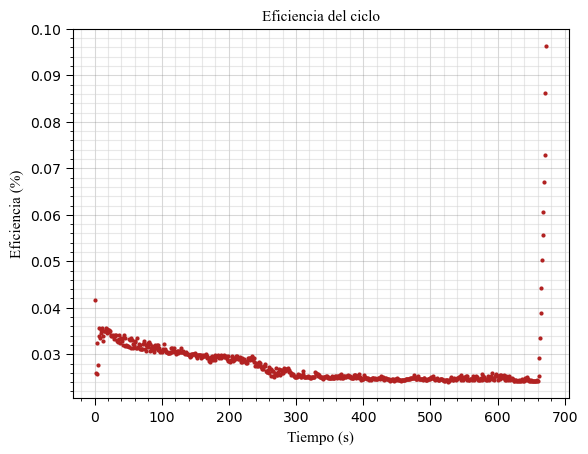

In [163]:
#Plot de eficiencia del ciclo
df_filtered=(df[df["Time (sec)"]>1500]).reset_index(drop=True)

plot_ufloats(df_filtered['Time (sec)']-1500,df_filtered['Eficiencia_ciclo'])
grafica("Eficiencia del ciclo","Tiempo (s)","Eficiencia (%)")

In [164]:
#Eficiencia del ciclo con el error aleatorio
aplicar_incertidumbre2(df_filtered['Eficiencia_ciclo'],0.1)

0.02769405784281095+/-0.1000009000945419

In [165]:
#Estimamos los estados para la gráfica T-s
T_in=15+273.15
S_in=PropsSI('S','T',T_in,'P',75483,'Water')

T_boiler=aplicar_incertidumbre2(df_filtered["Boiler Temp (K)"],0.1)
T_boiler

S_boiler=aplicar_incertidumbre2(df_filtered["Boiler Entropy (J/kg)"],0.1)
S_boiler

T_turbine_in=aplicar_incertidumbre2(df_filtered["Turbine In Temp (K)"],0.1)
T_turbine_in

S_turbine_in=aplicar_incertidumbre2(df_filtered["Turbine In Entropy (J/kg)"],0.1)
S_turbine_in

T_turbine_ex=aplicar_incertidumbre2(df_filtered["Turbine Ex Temp (K)"],0.1)
T_turbine_ex

S_turbine_ex=aplicar_incertidumbre2(df_filtered["Turbine Ex Entropy (J/kg)"],0.1)



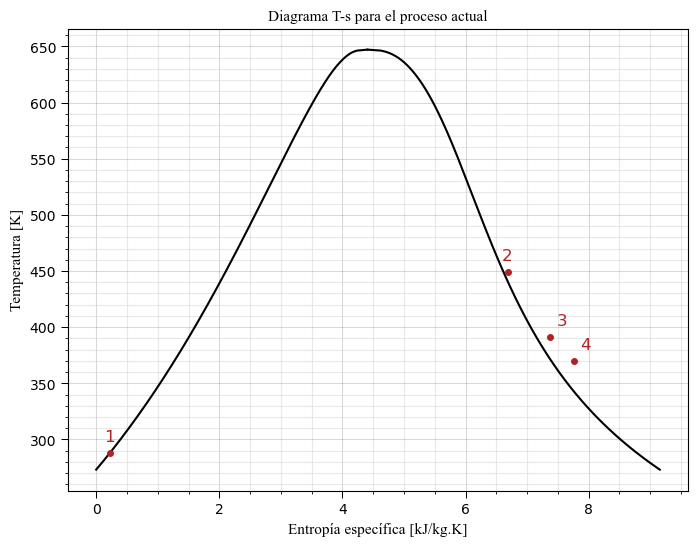

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

# Fluido seleccionado
fluido = 'Water'

# Rango de temperaturas (en Kelvin)
T_min = 273.15  # 0°C
T_max = 700.15  # 350°C
T_values = np.linspace(T_min, T_max, 500)

# Valores de presión en Pa (ejemplo: presión de saturación)
p_value = 1e5  # 1 bar

# Arrays para almacenar los valores de entropía y temperatura
s_liquid = []
s_vapor = []
T_liquid = []
T_vapor = []

# Calcular valores en función de la temperatura
for T in T_values:
    try:
        # Entropía para la fase líquida (subenfriada o saturada)
        s_liq = PropsSI('S', 'T', T, 'Q', 0, fluido)
        s_liquid.append(s_liq)
        T_liquid.append(T)

        # Entropía para la fase de vapor (saturada o sobrecalentada)
        s_vap = PropsSI('S', 'T', T, 'Q', 1, fluido)
        s_vapor.append(s_vap)
        T_vapor.append(T)
    except:
        pass  # Evitar errores de fases imposibles

# Convertir las listas a arrays numpy
s_liquid = np.array(s_liquid)
s_vapor = np.array(s_vapor)
T_liquid = np.array(T_liquid)
T_vapor = np.array(T_vapor)

# Graficar el diagrama T-s
plt.figure(figsize=(8, 6))
plt.plot(s_liquid / 1000, T_liquid, color='black')
plt.plot(s_vapor / 1000, T_vapor, color='black')

# Etiquetas y título
#Entrada
plt.plot([S_in/1000],[T_in],marker='o',color="firebrick",markersize=4)
plt.annotate('1', 
             xy=(S_in/1000, T_in),  # Coordenadas del punto a anotar
             xytext=(S_in/1000 - 0.1, T_in + 10),  # Posición del texto
             fontsize=12,
             color="firebrick")

# Caldera
plot_ufloats2([S_boiler/1000],[T_boiler])
plt.annotate('2', 
             xy=(S_boiler.nominal_value/1000, T_boiler.nominal_value),  # Coordenadas del punto a anotar
             xytext=(S_boiler.nominal_value/1000 - 0.1, T_boiler.nominal_value + 10),  # Posición del texto
             fontsize=12,
             color="firebrick")
#Entrada turbina
plot_ufloats2([S_turbine_in/1000],[T_turbine_in])
plt.annotate('3', 
             xy=(S_turbine_in.nominal_value/1000, T_turbine_in.nominal_value),  # Coordenadas del punto a anotar
             xytext=(S_turbine_in.nominal_value/1000 + 0.1, T_turbine_in.nominal_value + 10),  # Posición del texto
             fontsize=12,
             color="firebrick")
#Salida turbina
plot_ufloats2([S_turbine_ex/1000],[T_turbine_ex])
plt.annotate('4', 
             xy=(S_turbine_ex.nominal_value/1000,T_turbine_ex.nominal_value),  # Coordenadas del punto a anotar
             xytext=(S_turbine_ex.nominal_value/1000 + 0.1, T_turbine_ex.nominal_value + 10),  # Posición del texto
             fontsize=12,
             color="firebrick")
# Mostrar la gráfica
grafica('Diagrama T-s para el proceso actual','Entropía específica [kJ/kg.K]','Temperatura [K]')
plt.show()



In [167]:
P_sat=PropsSI('P','T',T_boiler.nominal_value,'Q',0,'Water')
P_sat

S_sat=PropsSI('S','T',T_boiler.nominal_value,'Q',0,'Water')

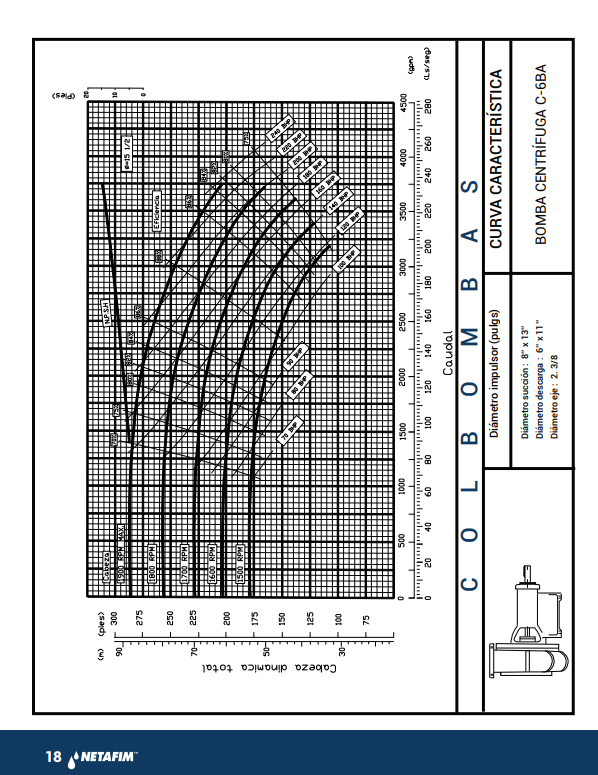

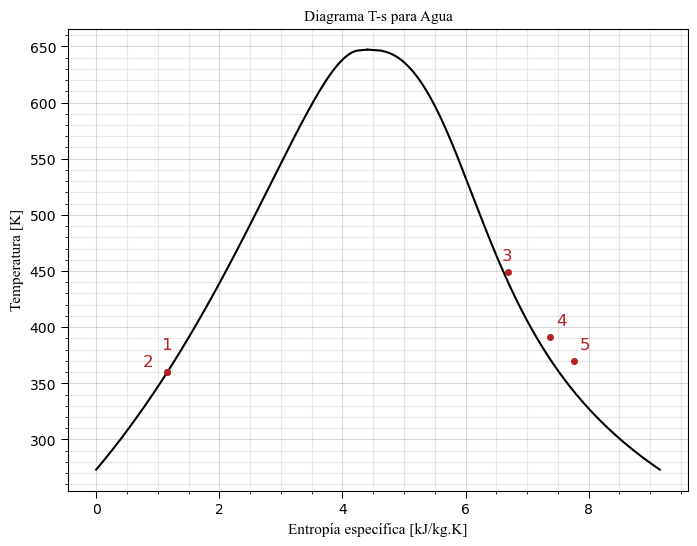

In [168]:
#Análisis computacional-Se cierra el ciclo de Rankine con una bomba centrífuga
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

# Fluido seleccionado
fluido = 'Water'

# Rango de temperaturas (en Kelvin)
T_min = 273.15  # 0°C
T_max = 700.15  # 350°C
T_values = np.linspace(T_min, T_max, 500)

# Valores de presión en Pa (ejemplo: presión de saturación)
p_value = 1e5  # 1 bar

# Arrays para almacenar los valores de entropía y temperatura
s_liquid = []
s_vapor = []
T_liquid = []
T_vapor = []

# Calcular valores en función de la temperatura
for T in T_values:
    try:
        # Entropía para la fase líquida (subenfriada o saturada)
        s_liq = PropsSI('S', 'T', T, 'Q', 0, fluido)
        s_liquid.append(s_liq)
        T_liquid.append(T)

        # Entropía para la fase de vapor (saturada o sobrecalentada)
        s_vap = PropsSI('S', 'T', T, 'Q', 1, fluido)
        s_vapor.append(s_vap)
        T_vapor.append(T)
    except:
        pass  # Evitar errores de fases imposibles

# Convertir las listas a arrays numpy
s_liquid = np.array(s_liquid)
s_vapor = np.array(s_vapor)
T_liquid = np.array(T_liquid)
T_vapor = np.array(T_vapor)

S_in=PropsSI('S','T',T_turbine_ex.nominal_value-10,'Q',0,'Water')

# Graficar el diagrama T-s
plt.figure(figsize=(8, 6))
plt.plot(s_liquid / 1000, T_liquid, color='black')
plt.plot(s_vapor / 1000, T_vapor, color='black')

# Etiquetas y título
#Entrada
P_in=PropsSI('P','T',T_turbine_ex.nominal_value-10,'S',S_in,'Water')
plt.plot([S_in/1000],[T_turbine_ex.nominal_value-10],marker='o',color="firebrick",markersize=4)
plt.annotate('1', 
             xy=( S_in/1000,T_turbine_ex.nominal_value),  # Coordenadas del punto a anotar
             xytext=(S_in/1000 - 0.1, T_turbine_ex.nominal_value+10),  # Posición del texto
             fontsize=12,
             color="firebrick")

# Bomba Imaginaria
T_pump=PropsSI('T','P',P_sat,'S',S_in,'Water')
P_pump=PropsSI('P','T',T_pump,'S',S_in,'Water')
plt.plot([S_in/1000],[T_pump],marker='o',color="firebrick",markersize=4)
plt.annotate('2', 
             xy=( S_in/1000,T_pump),  # Coordenadas del punto a anotar
             xytext=(S_in/1000 - 0.4, T_pump+5),  # Posición del texto
             fontsize=12,
             color="firebrick")


# Caldera
plot_ufloats2([S_boiler/1000],[T_boiler])
plt.annotate('3', 
             xy=(S_boiler.nominal_value/1000, T_boiler.nominal_value),  # Coordenadas del punto a anotar
             xytext=(S_boiler.nominal_value/1000 - 0.1, T_boiler.nominal_value + 10),  # Posición del texto
             fontsize=12,
             color="firebrick")
#Entrada turbina
plot_ufloats2([S_turbine_in/1000],[T_turbine_in])
plt.annotate('4', 
             xy=(S_turbine_in.nominal_value/1000, T_turbine_in.nominal_value),  # Coordenadas del punto a anotar
             xytext=(S_turbine_in.nominal_value/1000 + 0.1, T_turbine_in.nominal_value + 10),  # Posición del texto
             fontsize=12,
             color="firebrick")
#Salida turbina
P_turbine_ex=PropsSI('P','T',T_turbine_ex.nominal_value,'S',S_turbine_ex.nominal_value,'Water')
plot_ufloats2([S_turbine_ex/1000],[T_turbine_ex])
plt.annotate('5', 
             xy=(S_turbine_ex.nominal_value/1000,T_turbine_ex.nominal_value),  # Coordenadas del punto a anotar
             xytext=(S_turbine_ex.nominal_value/1000 + 0.1, T_turbine_ex.nominal_value + 10),  # Posición del texto
             fontsize=12,
             color="firebrick")
# Mostrar la gráfica
grafica('Diagrama T-s para Agua','Entropía específica [kJ/kg.K]','Temperatura [K]')
plt.show()



In [169]:
#Estimación de la bomba necesaria para cerrar el ciclo
D=4e-3
V_dot=(0.0048-0.0016)/600

vel=V_dot/(np.pi*D**2/4)
vel

Re=1000*vel*D/0.001
Re

f=0.03771361225692398
L=1.5
h_f=f*L*vel**2/(D*2*9.81)


h_main=(P_pump-P_in)/(997*9.81)


h_f+h_main

87.39267032348042